In [8]:
import pandas as pd
import xlrd
import plotly.express as px
 
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import datetime as dt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import  mean_absolute_percentage_error

import pmdarima as pmd 
from pmdarima import model_selection

In [9]:
df = pd.read_excel('https://github.com/robertasgabrys/Forecasting/blob/main/SantiagoChileTransportationData.xlsx?raw=true')

In [10]:
df.tail(20)

,DATE,TIME,DEMAND
1303,2005-03-21,17:15:00,51
1304,2005-03-21,17:30:00,3
1305,2005-03-21,17:45:00,0
1306,2005-03-21,18:00:00,0
1307,2005-03-21,18:15:00,0
1308,2005-03-21,18:30:00,65
1309,2005-03-21,18:45:00,108
1310,2005-03-21,19:00:00,101
1311,2005-03-21,19:15:00,105
1312,2005-03-21,19:30:00,74


In [11]:
df.dtypes

DATE      datetime64[ns]
TIME              object
DEMAND             int64
dtype: object

In [12]:
# we want to concatenate DATE and TIME into one column: first we will convert DATE and TIME to string 
# Then we will use + operator to concatenate two strings into one, and finally convert string date+time to datetime format

df['DATETIME'] = pd.to_datetime(df['DATE'].astype(str) + ' ' + df['TIME'].astype(str))


In [13]:
df['INDEX'] = range(1, len(df)+1)

In [14]:
# plotting

fig = px.line(df, x='INDEX', y='DEMAND', markers=True) # Date time으로 해주면 버스 운행 없는 시간에 연결시켜 의도치 않은 트렌드를 만들어준다.
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [15]:
# Pattern : the data has daily and weekly seasonality. 
# and potentially downward trend.  

# How do we capture daily seasonality(daily cycle, within a day)? 
# We need to know how many data points represent one seasonal(daily) cycle.

In [16]:
# How many data points are in one daily seasonal cycle?
# start 6:30am - finish 22:00pm 
sum(df['DATE'] == '2005-03-01') # sum function converts True to 1 and False 0

# 하루에 63개의 15분 demand 데이터 포인트 있다.

63

In [17]:
df.head()

,DATE,TIME,DEMAND,DATETIME,INDEX
0,2005-03-01,06:30:00,1,2005-03-01 06:30:00,1
1,2005-03-01,06:45:00,2,2005-03-01 06:45:00,2
2,2005-03-01,07:00:00,4,2005-03-01 07:00:00,3
3,2005-03-01,07:15:00,0,2005-03-01 07:15:00,4
4,2005-03-01,07:30:00,10,2005-03-01 07:30:00,5


In [18]:
# Build a regression model to model daily seasonality

M1 = smf.ols('DEMAND ~ C(DATE)', data=df).fit()
print(M1.summary())

                            OLS Regression Results                            
Dep. Variable:                 DEMAND   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     43.79
Date:                Sat, 10 Dec 2022   Prob (F-statistic):          6.22e-130
Time:                        15:02:40   Log-Likelihood:                -5714.4
No. Observations:                1323   AIC:                         1.147e+04
Df Residuals:                    1302   BIC:                         1.158e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [19]:
M1.rsquared

0.40216850664960946

<AxesSubplot:>

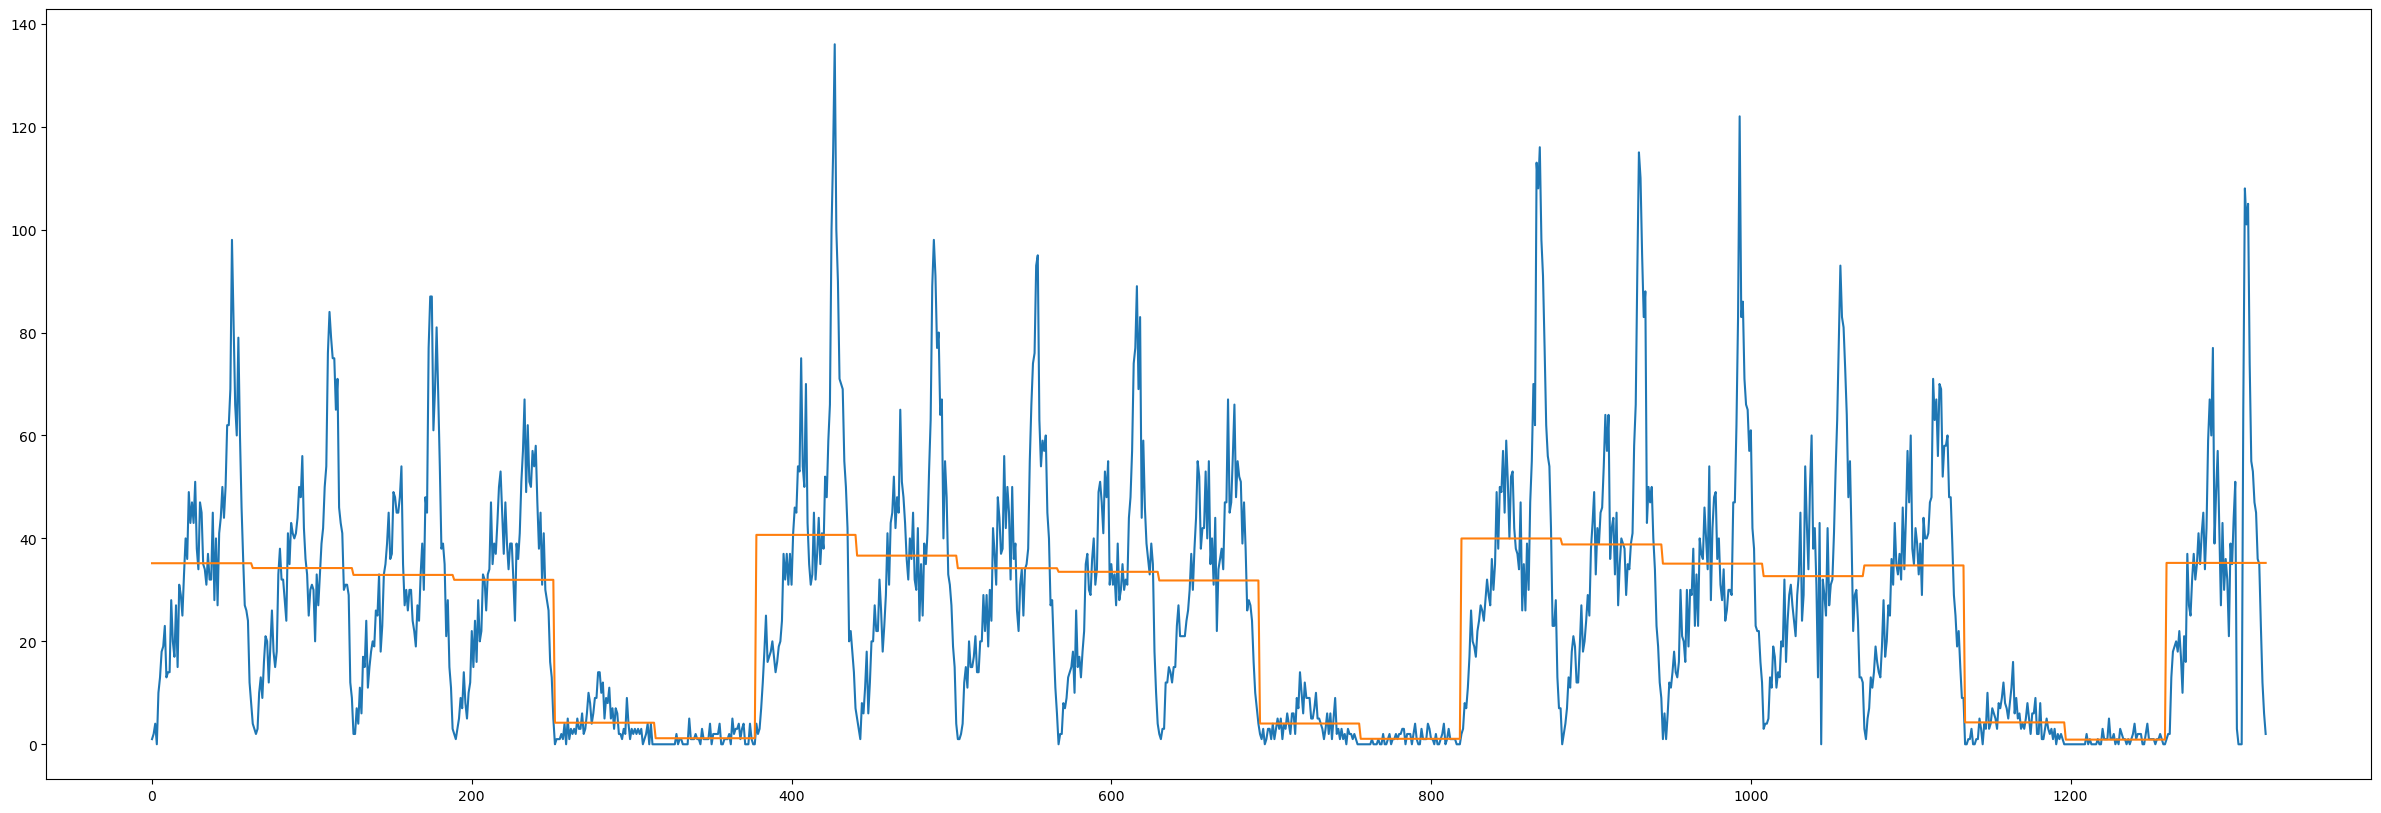

In [20]:
# How good a model? Plot data and overlay fitted values
df['DEMAND'].plot(figsize=(30,10))
M1.fittedvalues.plot()

In [21]:
# calculate MAPE of this model's predictions
mean_absolute_percentage_error(y_true = df['DEMAND'], y_pred = M1.fittedvalues)

1374276271131420.5

In [22]:
# If actual values contain zeros MAPE is NOT appropriate metric accuracy, because of division by zero leading to infinity
# are there any points that have demand of zero? and how many?

sum(df['DEMAND'] == 0)

107

In [23]:
mean_absolute_percentage_error(y_true = df.loc[df['DEMAND'] !=0, 'DEMAND'], y_pred = M1.fittedvalues[df['DEMAND'] !=0])*100

127.52814665148958

In [24]:
df['DEMAND'] != 0 

0        True
1        True
2        True
3       False
4        True
        ...  
1318     True
1319     True
1320     True
1321     True
1322     True
Name: DEMAND, Length: 1323, dtype: bool

In [25]:
# Define the function to return the SMAPE value
def smape(y_true, y_pred):
    return round(100*np.mean(2 * np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)))),3)

In [26]:
smape(y_true = df['DEMAND'], y_pred=M1.fittedvalues)

63.085

In [27]:
# M1 did not capture daily seasonality. 
# Now let's extract minute from time variable
df['MINUTE'] = df['DATETIME'].dt.minute

In [28]:
# Build a regression model to model daily seasonality

M2 = smf.ols('DEMAND ~ C(MINUTE)', data=df).fit()
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:                 DEMAND   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.046
Date:                Sat, 10 Dec 2022   Prob (F-statistic):              0.371
Time:                        15:02:41   Log-Likelihood:                -6053.2
No. Observations:                1323   AIC:                         1.211e+04
Df Residuals:                    1319   BIC:                         1.214e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          24.9315      1.283     

In [29]:
M2.rsquared

0.002372967022949868

<AxesSubplot:>

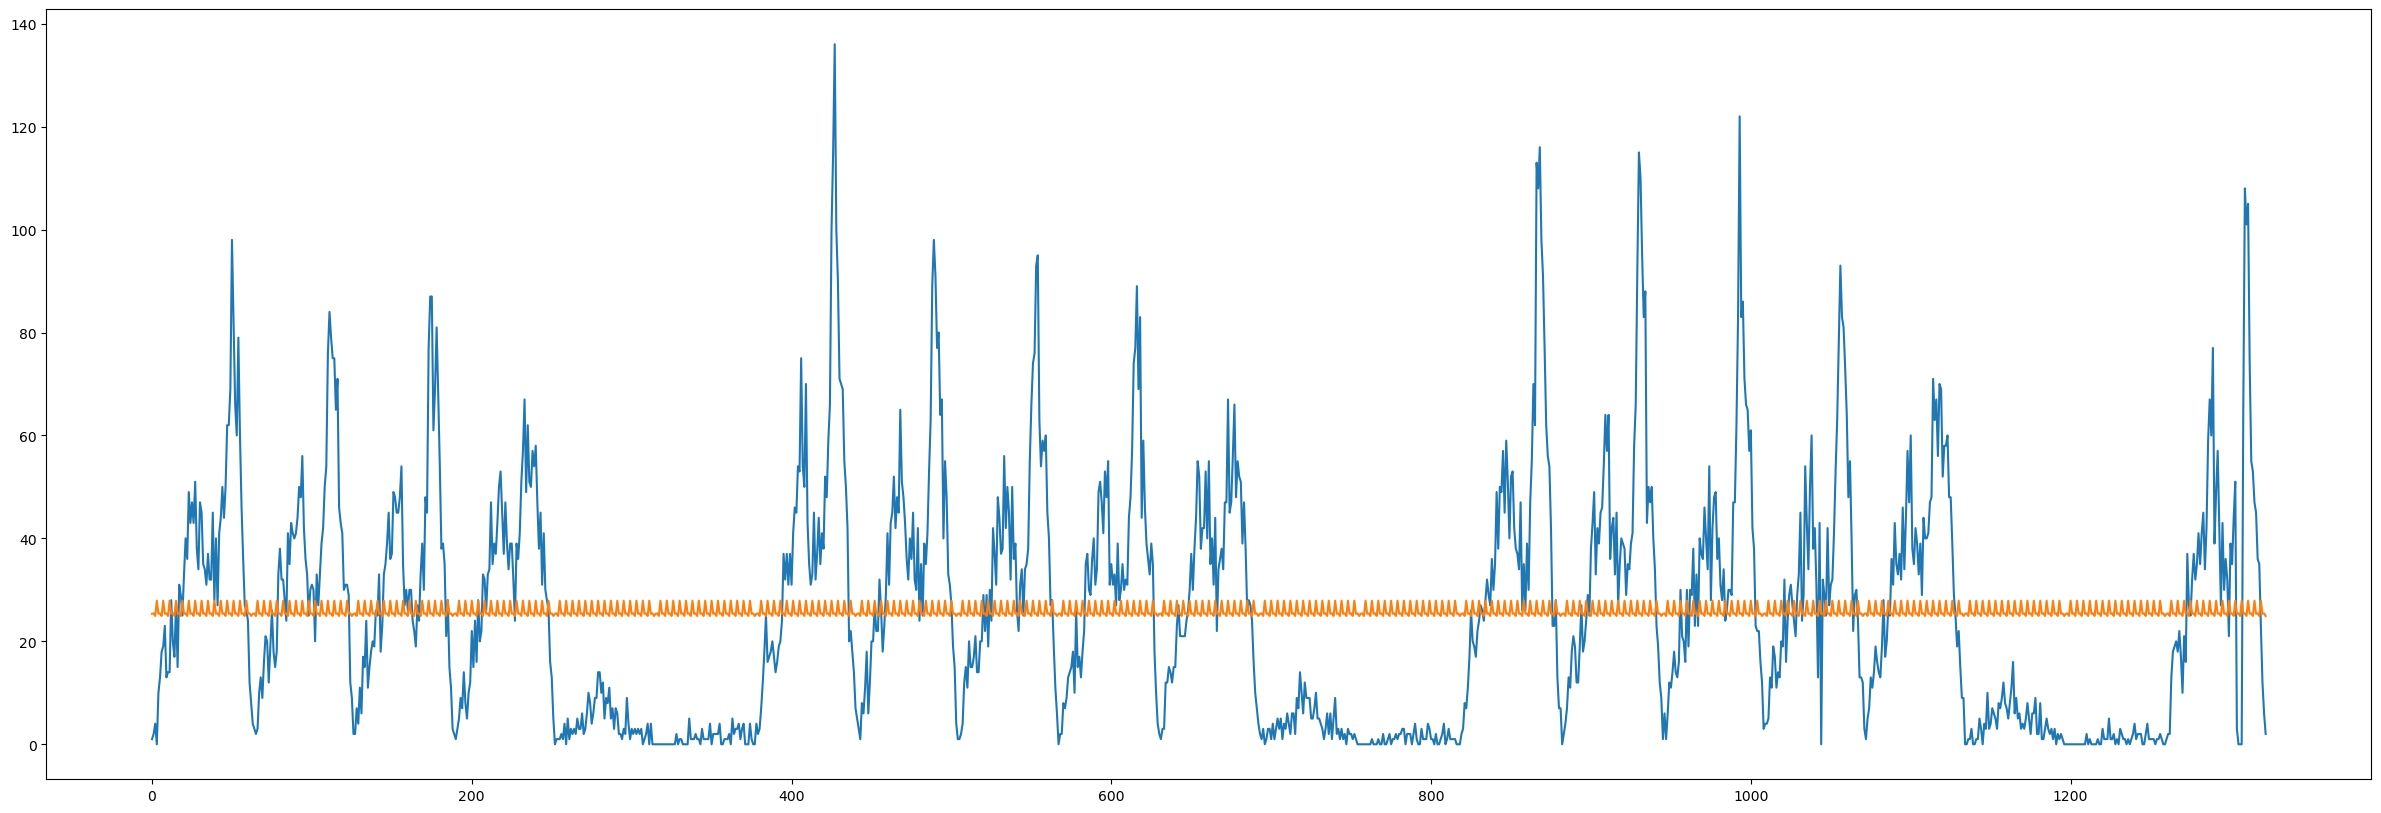

In [30]:
# How good a model? Plot data and overlay fitted values
df['DEMAND'].plot(figsize=(30,10))
M2.fittedvalues.plot()

In [31]:
# We can use Time column. Since Time does not have seconds we can remove seconds
df['HourMin'] = df['DATETIME'].dt.strftime('%H:%M').astype(str)

In [32]:
df.head()

,DATE,TIME,DEMAND,DATETIME,INDEX,MINUTE,HourMin
0,2005-03-01,06:30:00,1,2005-03-01 06:30:00,1,30,06:30
1,2005-03-01,06:45:00,2,2005-03-01 06:45:00,2,45,06:45
2,2005-03-01,07:00:00,4,2005-03-01 07:00:00,3,0,07:00
3,2005-03-01,07:15:00,0,2005-03-01 07:15:00,4,15,07:15
4,2005-03-01,07:30:00,10,2005-03-01 07:30:00,5,30,07:30


In [61]:
M3 = smf.ols('DEMAND ~ C(HourMin)', data=df).fit()
print(M3.summary())  # 각 15분 시간대를 더미로 만들어준다. 

                            OLS Regression Results                            
Dep. Variable:                 DEMAND   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     11.63
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           8.98e-86
Time:                        12:45:19   Log-Likelihood:                -5755.5
No. Observations:                1323   AIC:                         1.164e+04
Df Residuals:                    1260   BIC:                         1.196e+04
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.5714    

In [62]:
M3.rsquared

0.3639177998945441

<AxesSubplot:>

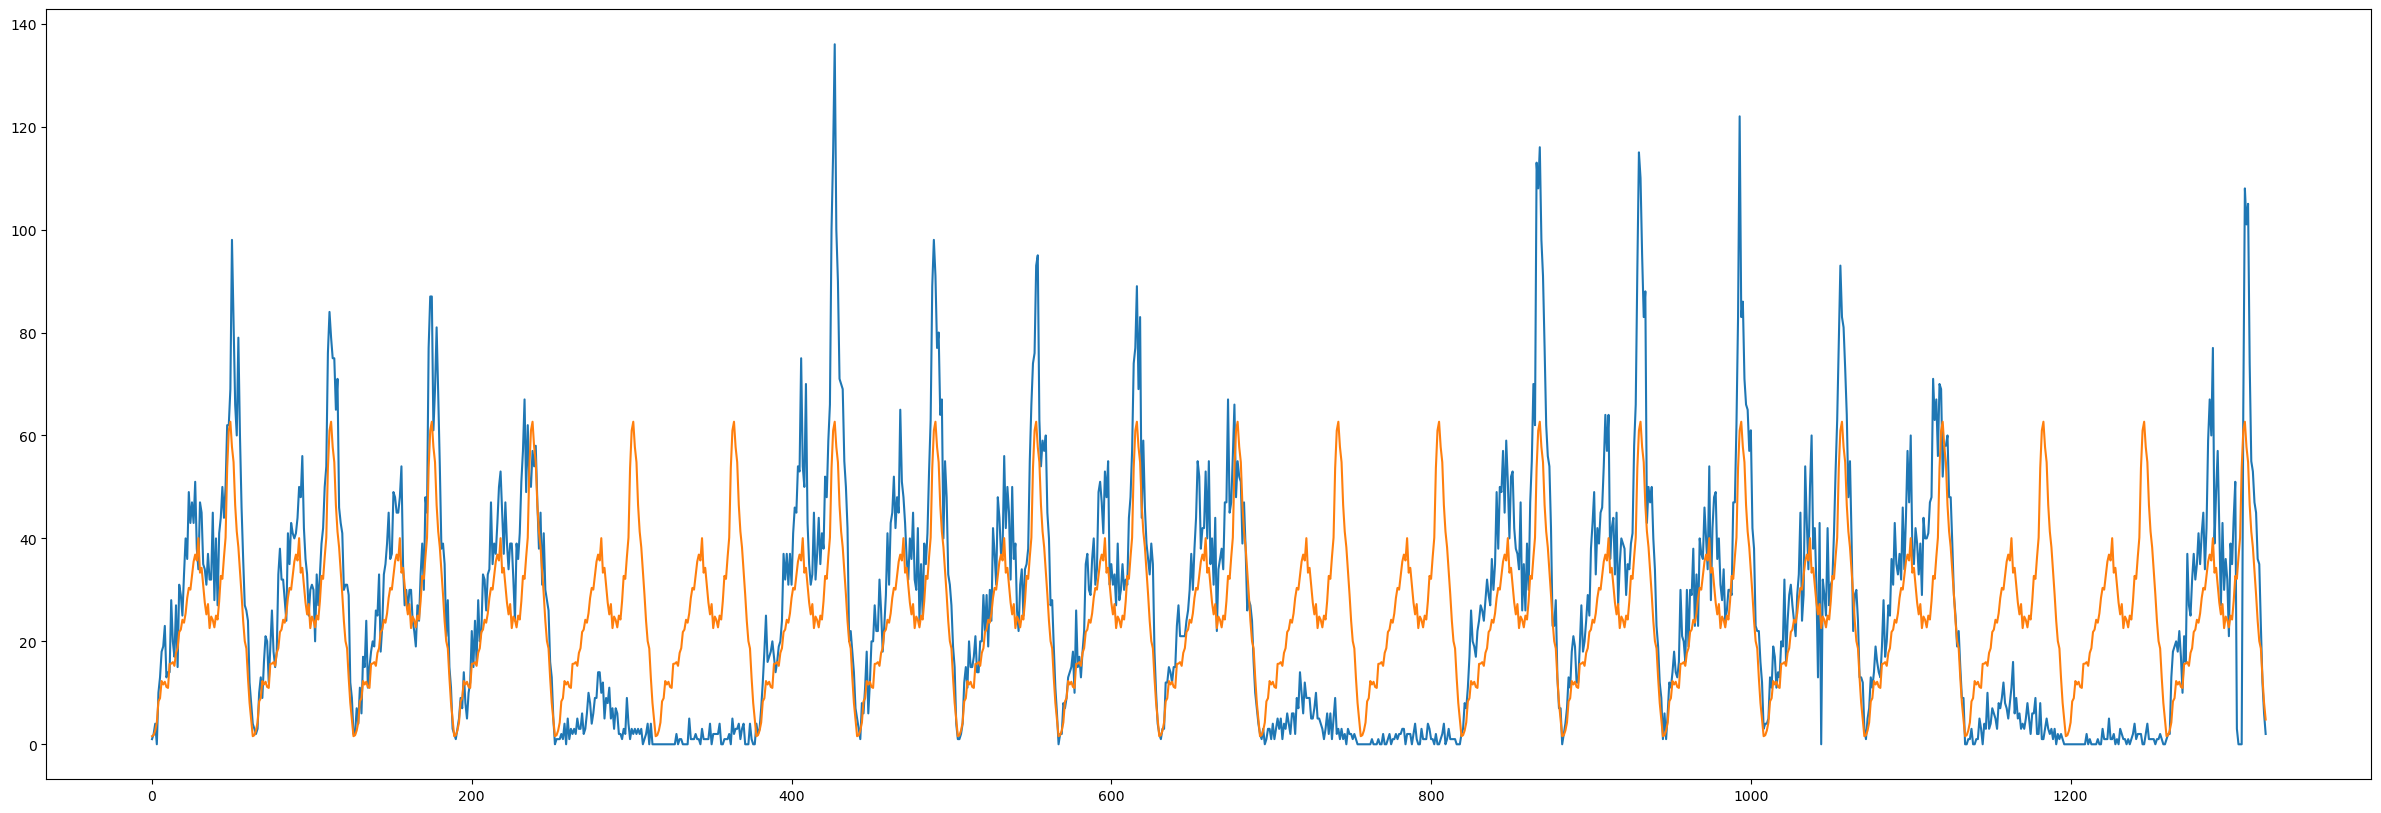

In [63]:
# How good a model? Plot data and overlay fitted values
df['DEMAND'].plot(figsize=(30,10))
M3.fittedvalues.plot()

In [68]:
# Daily seasonal patterns depend on the day of the week.
# To take the day of the week into consideration, let's design feature DayofWeek

df['DayOfWeek'] = df['DATETIME'].dt.day_name()
df.head()

,DATE,TIME,DEMAND,DATETIME,INDEX,MINUTE,HourMin,DayOfWeek
0,2005-03-01,06:30:00,1,2005-03-01 06:30:00,1,30,06:30,Tuesday
1,2005-03-01,06:45:00,2,2005-03-01 06:45:00,2,45,06:45,Tuesday
2,2005-03-01,07:00:00,4,2005-03-01 07:00:00,3,0,07:00,Tuesday
3,2005-03-01,07:15:00,0,2005-03-01 07:15:00,4,15,07:15,Tuesday
4,2005-03-01,07:30:00,10,2005-03-01 07:30:00,5,30,07:30,Tuesday


In [73]:
# Build a regression model to model daily and day of week seasonality

M4 = smf.ols('DEMAND ~ C(HourMin) + C(DayOfWeek)', data=df).fit()
print(M4.summary())

                            OLS Regression Results                            
Dep. Variable:                 DEMAND   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     59.52
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:56:05   Log-Likelihood:                -5101.2
No. Observations:                1323   AIC:                         1.034e+04
Df Residuals:                    1254   BIC:                         1.070e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

<AxesSubplot:>

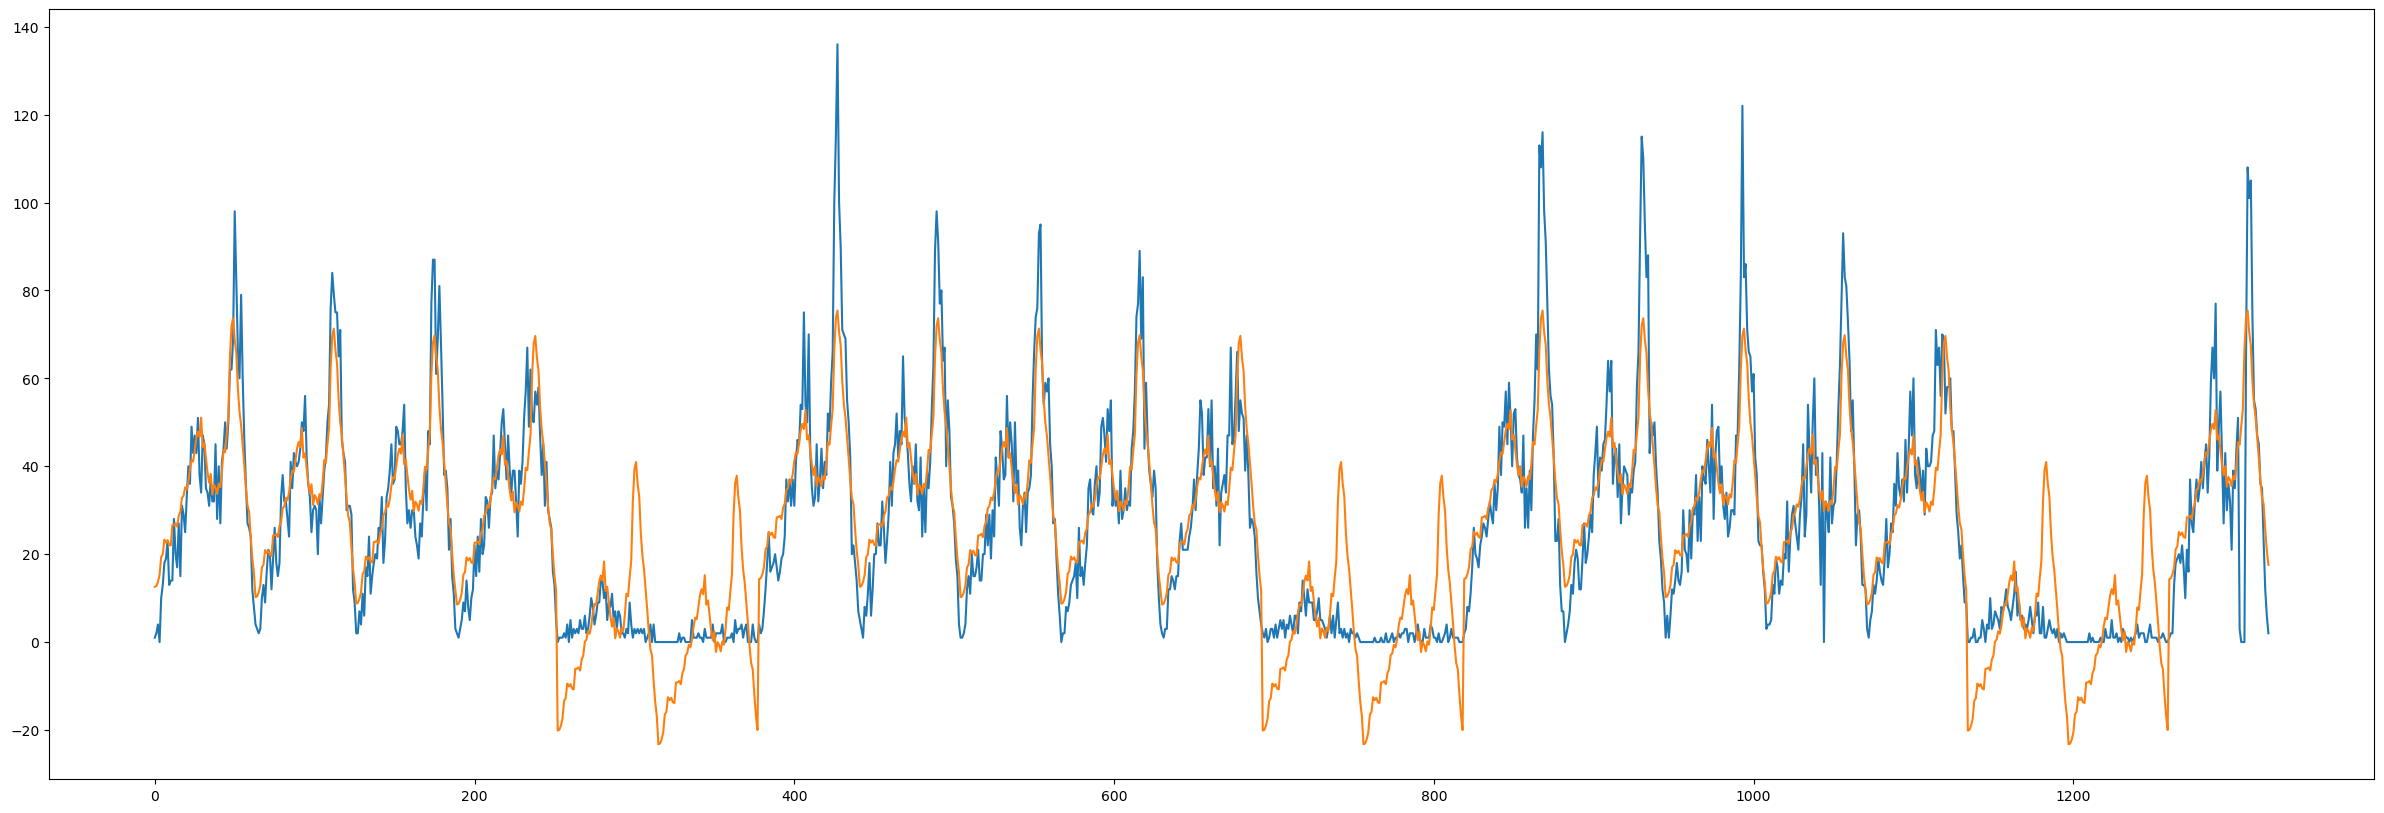

In [74]:
df['DEMAND'].plot(figsize=(30,10))
M4.fittedvalues.plot()

In [75]:
# On weekends the aplitude of seasonal cycle is much smaller than weekdays.
# to capture it we need to create "interaction term"
# a*b = a+b+a:b = main effects a and b and interaction between a:b 
# a*b*c = a + b + c + a:b + a:c + b:c + a:b:c

M5 = smf.ols('DEMAND ~ C(HourMin) * C(DayOfWeek)', data=df).fit()
print(M5.summary())

                            OLS Regression Results                            
Dep. Variable:                 DEMAND   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     31.15
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:58:53   Log-Likelihood:                -4198.7
No. Observations:                1323   AIC:                             9279.
Df Residuals:                     882   BIC:                         1.157e+04
Df Model:                         440                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

<AxesSubplot:>

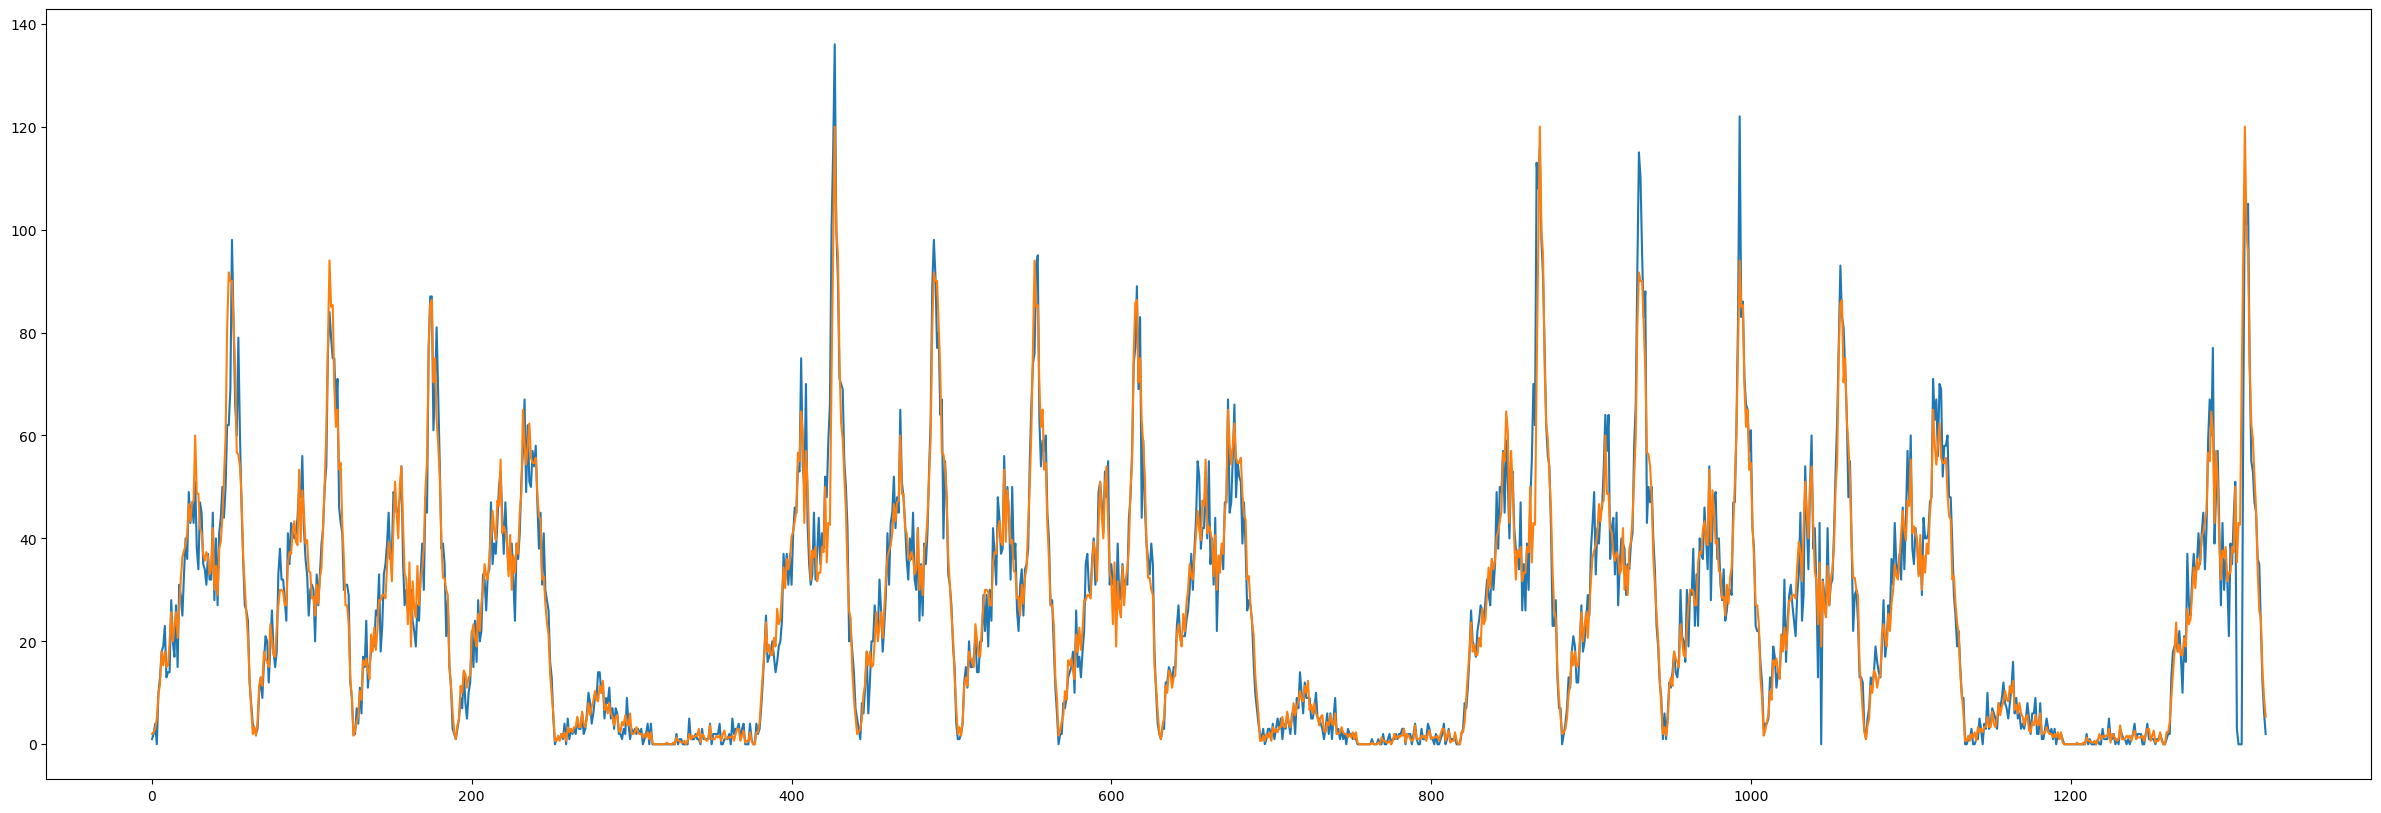

In [76]:
df['DEMAND'].plot(figsize=(30,10))
M5.fittedvalues.plot()

In [77]:
# store M1, M2, ..., M5 predicted values in columns of df:
df['M1'] = M1.fittedvalues
df['M2'] = M2.fittedvalues
df['M3'] = M3.fittedvalues
df['M4'] = M4.fittedvalues
df['M5'] = M5.fittedvalues

In [79]:
fig=px.line(df, x='INDEX', y=['DEMAND', 'M5'], markers=True)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [80]:
mean_absolute_percentage_error(y_true = df.loc[df['DEMAND'] !=0, 'DEMAND'], y_pred = M5.fittedvalues[df['DEMAND'] !=0])*100

23.246139971264927

In [81]:
smape(y_true = df['DEMAND'], y_pred=M5.fittedvalues)

34.87

In [82]:
# How to create a design matrix for machine learning models:
# https://patsy.readthedocs.io/en/latest/categorical-coding.html

from patsy import dmatrices


In [88]:
y, X = dmatrices('DEMAND ~ 0 + C(HourMin)*C(DayOfWeek) + INDEX + I(INDEX**2)', data=df, return_type='dataframe')
# add 0 if you do not want to include intercept


In [87]:
X

,Intercept,C(HourMin)[T.06:45],C(HourMin)[T.07:00],C(HourMin)[T.07:15],C(HourMin)[T.07:30],C(HourMin)[T.07:45],C(HourMin)[T.08:00],C(HourMin)[T.08:15],C(HourMin)[T.08:30],C(HourMin)[T.08:45],...,C(HourMin)[T.20:15]:C(DayOfWeek)[T.Wednesday],C(HourMin)[T.20:30]:C(DayOfWeek)[T.Wednesday],C(HourMin)[T.20:45]:C(DayOfWeek)[T.Wednesday],C(HourMin)[T.21:00]:C(DayOfWeek)[T.Wednesday],C(HourMin)[T.21:15]:C(DayOfWeek)[T.Wednesday],C(HourMin)[T.21:30]:C(DayOfWeek)[T.Wednesday],C(HourMin)[T.21:45]:C(DayOfWeek)[T.Wednesday],C(HourMin)[T.22:00]:C(DayOfWeek)[T.Wednesday],INDEX,I(INDEX ** 2)
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,16.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1319.0,1739761.0
1319,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1320.0,1742400.0
1320,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1321.0,1745041.0
1321,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1322.0,1747684.0


In [89]:
# pycaret library examples 

# https://nbviewer.org/github/pycaret/pycaret/tree/master/examples/time_series/forecasting/
# https://pycaret.readthedocs.io/en/latest/api/time_series.html
